# Análisis: seguro de vehículos


Una empresa de seguros de salud quiere ofrecer a sus antiguos clientes un nuevo seguro de vehículos. Necesita nuestro servicio para crear un modelo que prediga si un cliente estaría interesado en este nuevo seguro.

Tenemos un conjunto de datos con los siguientes valores:

| Variable | Definición |
| --- | --- |
| id | Identificador único |
| Gender | Género del cliente (M/F) |
| Age | Edad del cliente |
| Driving_License | El cliente tiene carnet de conducir (1/0) |
| Region_Code | Código de la región del cliente |
| Previously_Insured | El cliente ya tiene seguro de coche (1/0) |
| Vehicle_Age | Años del vehículo |
| Vehicle_Damage | El cliente ha sufrido daños en su vehículo anteriormente (1/0) |
| Annual_Premium | Cantidad a pagar por el nuevo seguro |
| Plocy_Sales_Channel | Canal por el que se localiza al cliente (e-mail, teléfono, en persona, etc) |
| Vintage | Número de días del cliente con la compañía |
| Response | Respuesta si o no (1/0) |

### Problema de clasificación

## Importando y dividiendo Dataset

Importamos librerías necesarias y cargamos los dataset de entrenamiento y prueba desde la carpeta /res

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report



train = pd.read_csv('../res/train.csv')
x = train.iloc[:, 1:-1] # Training Dataset without dependient variable and index (pandas index = dataset index - 1)
y = train.iloc[:, -1] # Training Dependient variable

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

test_final = pd.read_csv('../res/test_final.csv').iloc[:, 1:] # Test Dataset variable and index (pandas index = dataset index - 1)

display(train)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


## Previsualización

En este apartado vamos a analizar visualmente el dataset para así poder analizar de una forma más sencilla como se comportan los clientes ante sus diferentes condiciones

Podemos considerar una de las variables más decisivas el hecho de haber recibido daños en el vehículo anteriormente y los años que tenga el vehiculo. Vamos a dividir además estas dos variables según el género del cliente. Comparamos las siguientes variables:

- Años del vehículo
- Daños anteriores en el vehículo
- Género
- Respuesta

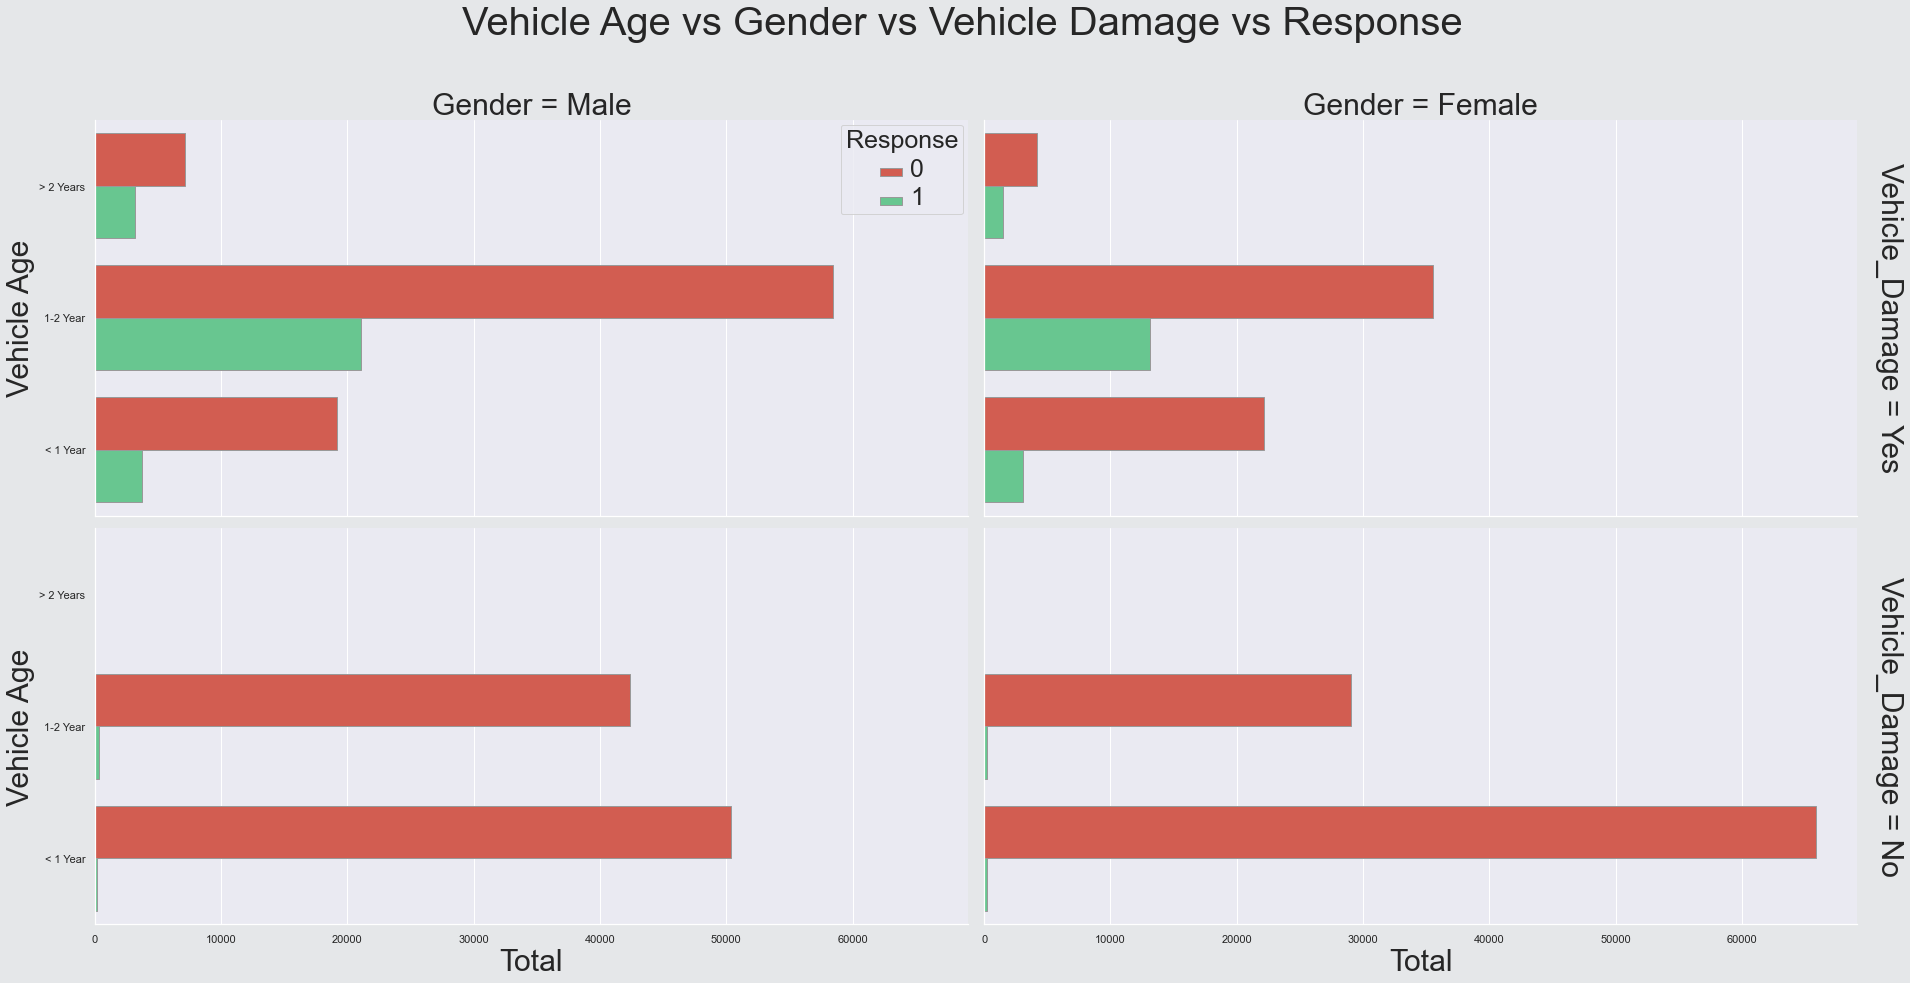

In [158]:
sns.set_theme(style="darkgrid")

g_vage_gender_vdama = sns.catplot(
    data = train,
    y = 'Vehicle_Age', hue = 'Response', col = 'Gender', row = 'Vehicle_Damage',    
    kind = 'count', height=6, aspect=13/6,    
    legend = True,  
    palette = sns.color_palette(['#E74C3C', '#58D68D']),
    edgecolor = '.6',
    margin_titles = True,
    legend_out = False
    )

g_vage_gender_vdama.set_titles(size = '30')

g_vage_gender_vdama.set_axis_labels("Total", "Vehicle Age", size = '30')

g_vage_gender_vdama.fig.suptitle('Vehicle Age vs Gender vs Vehicle Damage vs Response', size = '40', y = 1.1)

plt.setp(g_vage_gender_vdama._legend.get_texts(), fontsize=25)
plt.setp(g_vage_gender_vdama._legend.get_title(), fontsize=25)

g_vage_gender_vdama.fig.patch.set_facecolor('#E5E7E9')

Podemos observar como prácticamente ningún cliente ha respondido de forma afirmativa cuando su vehiculo no ha recibido daños anteriormente. Esta variable (**Vehicle_Damage**) puede ser un discriminador sencillo y rápido a la hora de determinar la respuesta del cliente.

Por otro lado, las dos otras variables no parecen afectar demasiado en la decisión. Si bien, aunque no de forma clara, observamos alguna reticiencia en los clientes con vehiculos de menos de un año.

Algo que podemos observar de esta visualización es que el dataset no posee muchos datos sobre vehiculos no dañados mayores de dos años.

#### Veamos como se comportan los clientes que ya tienen seguro y no tienen carnet de conducir:

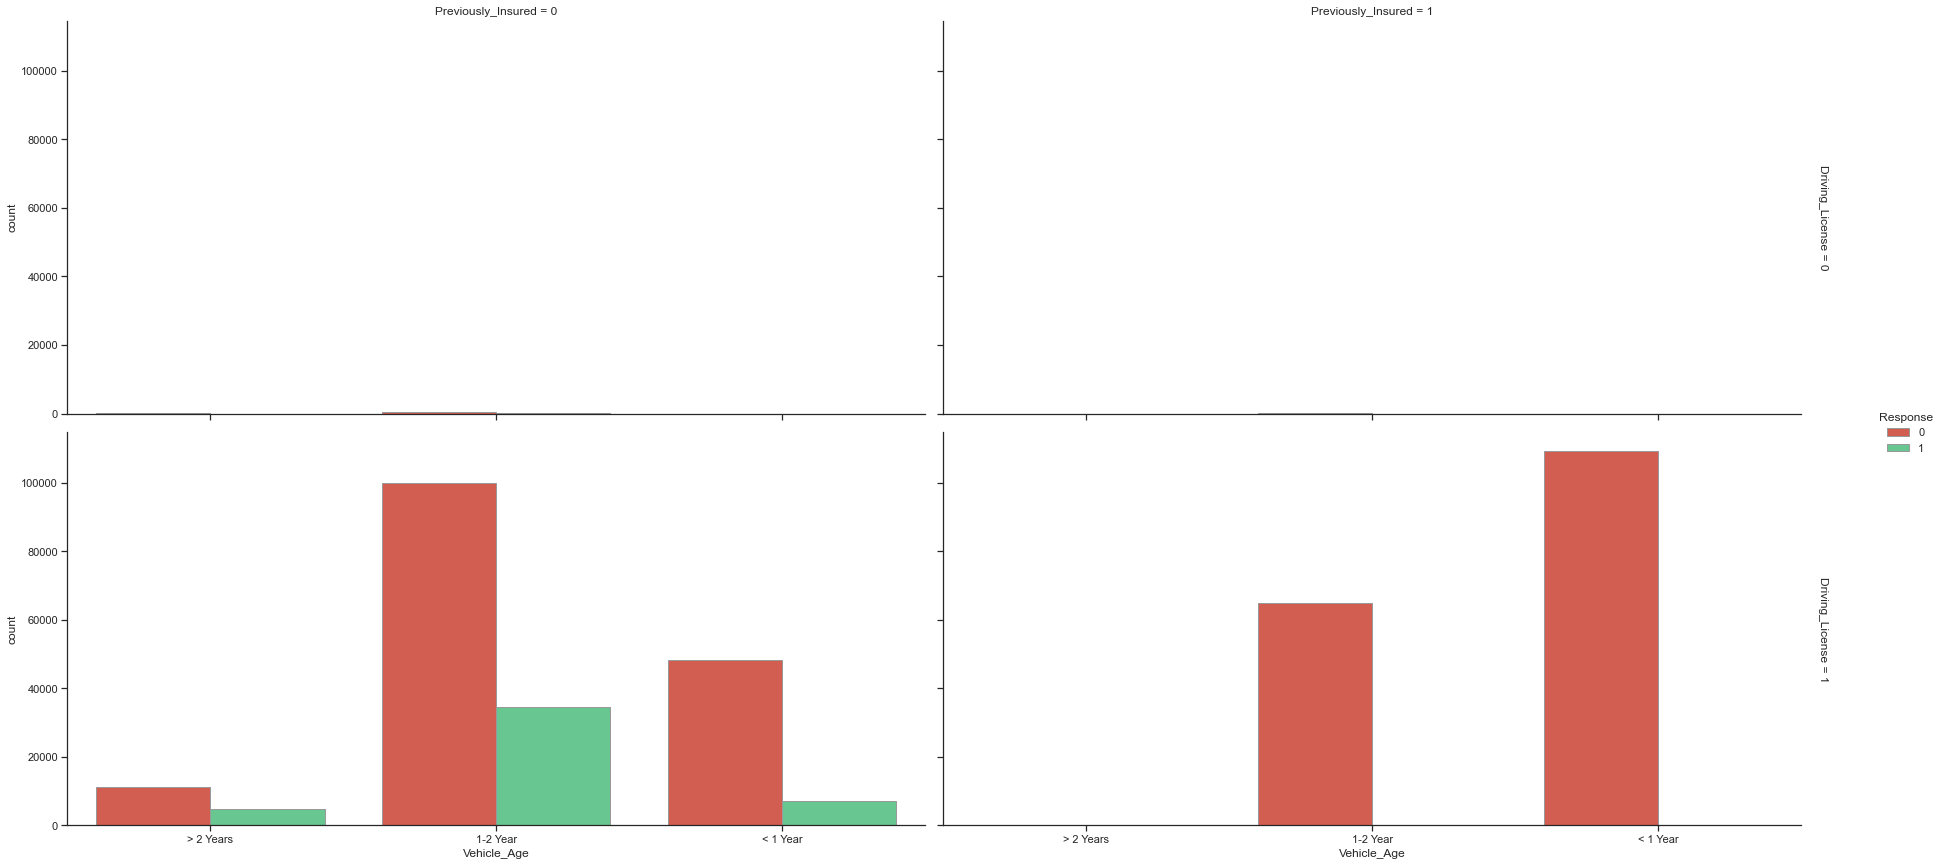

In [174]:
g_pins_vdama = sns.catplot(
    data = train,
    hue = 'Response', x = 'Vehicle_Age', col = 'Previously_Insured', row = 'Driving_License',    
    kind = 'count', height=6, aspect=13/6,    
    legend = True,  
    palette = sns.color_palette(['#E74C3C', '#58D68D']),
    edgecolor = '.6',
    margin_titles = True
)

Este nuevo gráfico nos da las siguientes pistas:

 - De nuevo podemos ver como los clientes que previamente han recibido daños en su vehiculo están más predispuestos a aceptar el seguro. 
 - Observamos ahora como ningún cliente que ya tiene seguro procede a aceptar nuestra oferta. 
 - Ningún cliente que no tenga carnet de conducir acepta nuestra oferta.

En el siguiente gráfico analizamos el comportamiento de los clientes por:

- Edad
- Localización
- Canal de comunicación

Graficos


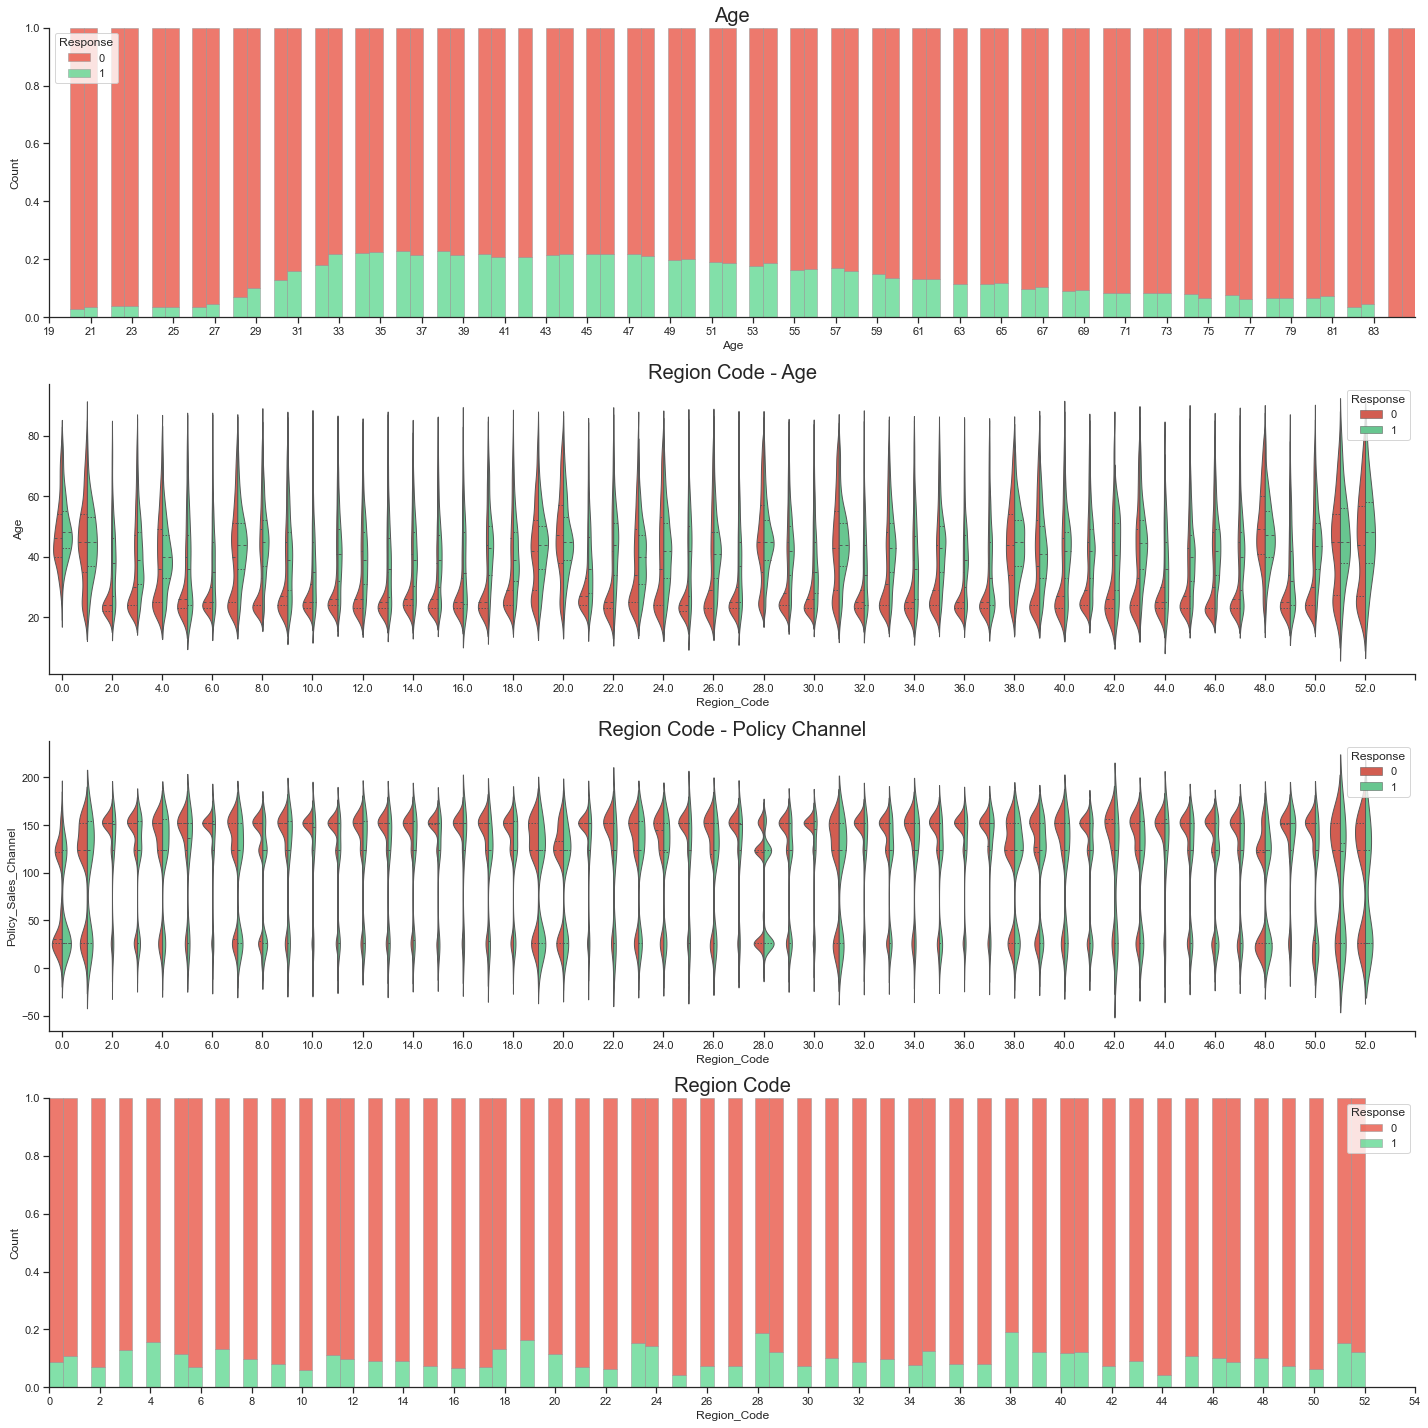

In [173]:
sns.set_theme(style = 'ticks')

fig, ax = plt.subplots(4, 1, figsize = (20, 20))

sns.despine(fig)

g_1 = sns.histplot(
    data = train,
    x = 'Age', hue = 'Response',
    multiple = 'fill',
    palette = sns.color_palette(['#E74C3C', '#58D68D']),
    edgecolor = '.6',
    linewidth = .5,
    ax = ax[0]
)

ax[0].set_xticks(np.arange(19, 85, 2))

g_2 = sns.violinplot(
    data = train,     
    x = 'Region_Code', y = 'Age', hue = 'Response', 
    split = True, inner = 'quart', linewidth = 1,
    palette = sns.color_palette(['#E74C3C', '#58D68D']),
    edgecolor = '.6',
    ax = ax[1]
)

ax[1].set_xticks(np.arange(0, 55, 2))

g_3 = sns.violinplot(
    data = train,     
    x = 'Region_Code', y = 'Policy_Sales_Channel', hue = 'Response', 
    split = True, inner = 'quartile', linewidth = 1,
    palette = sns.color_palette(['#E74C3C', '#58D68D']),
    edgecolor = '.6',
    ax = ax[2]
)
ax[2].set_xticks(np.arange(0, 55, 2))

g_1 = sns.histplot(
    data = train,
    x = 'Region_Code', hue = 'Response',
    multiple = 'fill',
    palette = sns.color_palette(['#E74C3C', '#58D68D']),
    edgecolor = '.6',
    linewidth = .5,
    ax = ax[3]
)
ax[3].set_xticks(np.arange(0, 55, 2))


ax[0].set_title('Age', fontsize=20)
ax[1].set_title('Region Code - Age', fontsize=20)
ax[2].set_title('Region Code - Policy Channel', fontsize=20)
ax[3].set_title('Region Code', fontsize=20)

fig.tight_layout() 

print('Graficos')

En estos gráficos observamos que:

- La franja de edad entre 33 - 55 años encontramos la mayoría de respuestas positivas a nuestra oferta
- Aunque tengamos respuestas positivas entre los 19 y los 27 años, la proporción de respuestas afirmativas es más baja que en las otras edades
- Los canales de comunicación cerca del 150 y parecen recibir una proporción muy mala de respuestas afirmativas
- No encontramos ningún patrón relevante en cuanto a la región del cliente

Analizamos la influencia de *Vintage* y *Anual_Premium* sobre la decisión de los clientes

ValueError: Index contains duplicate entries, cannot reshape

## Preprocesado y limpieza del Dataset

### Valores categóricos

Convertimos los valores categóricos en valores booleanos.

In [175]:
# Generate boolean values for categorical columns 
le = LabelEncoder()
x_train = pd.get_dummies(x_train, columns=['Gender', 'Vehicle_Age', 'Policy_Sales_Channel', 'Region_Code'], prefix=['Gender', 'Vehicle_Age', 'Policy_Sales_Channel', 'Region_Code'])
x_train['Vehicle_Damage'] = le.fit_transform(x_train['Vehicle_Damage']) # Yes -> 1 | No -> 0

x_test = pd.get_dummies(x_test, columns=['Gender', 'Vehicle_Age', 'Policy_Sales_Channel', 'Region_Code'], prefix=['Gender', 'Vehicle_Age', 'Policy_Sales_Channel', 'Region_Code'])
x_test['Vehicle_Damage'] = le.fit_transform(x_test['Vehicle_Damage']) # Yes -> 1 | No -> 0

display(x_train)
display(x_test)

# Reordering columns so categorical data are the last columns
cols = list(x_train.columns)
cols = cols[0:1] + cols[4:6] + cols[1:4] + cols[4:]
x_train = x_train[cols]

# Get missing columns in the training test
missing_cols = set( x_train.columns ) - set( x_test.columns )

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    x_test[c] = 0

# Ensure the order of column in the test set is in the same order than in train set
x_test = x_test[x_train.columns]

display(x_train)
display(x_test)

,Age,Driving_License,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,...,Region_Code_43.0,Region_Code_44.0,Region_Code_45.0,Region_Code_46.0,Region_Code_47.0,Region_Code_48.0,Region_Code_49.0,Region_Code_50.0,Region_Code_51.0,Region_Code_52.0
215357,31,1,0,1,27280.0,204,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
262812,43,1,1,0,2630.0,147,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
291557,25,1,1,1,2630.0,95,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
197937,53,1,0,1,45919.0,114,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
259434,26,1,1,0,55147.0,113,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359783,27,1,1,0,33223.0,220,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
358083,53,1,0,1,40971.0,131,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
152315,22,1,1,0,30400.0,118,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
117952,56,1,0,1,34849.0,229,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


,Age,Driving_License,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,...,Region_Code_43.0,Region_Code_44.0,Region_Code_45.0,Region_Code_46.0,Region_Code_47.0,Region_Code_48.0,Region_Code_49.0,Region_Code_50.0,Region_Code_51.0,Region_Code_52.0
220145,24,1,1,0,38744.0,267,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
194704,41,1,0,1,24929.0,156,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
203625,72,1,0,1,113486.0,70,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
218048,43,1,0,1,2630.0,209,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
230458,25,1,1,1,62383.0,20,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173172,62,1,0,1,32336.0,128,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
25252,23,1,1,0,2630.0,144,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
50493,26,1,1,0,39125.0,240,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
326182,49,1,0,1,37143.0,72,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


,Age,Annual_Premium,Vintage,Driving_License,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Gender_Female,Gender_Male,...,Region_Code_43.0,Region_Code_44.0,Region_Code_45.0,Region_Code_46.0,Region_Code_47.0,Region_Code_48.0,Region_Code_49.0,Region_Code_50.0,Region_Code_51.0,Region_Code_52.0
215357,31,27280.0,204,1,0,1,27280.0,204,0,1,...,0,0,0,0,0,0,0,0,0,0
262812,43,2630.0,147,1,1,0,2630.0,147,0,1,...,0,0,0,0,0,1,0,0,0,0
291557,25,2630.0,95,1,1,1,2630.0,95,0,1,...,0,0,0,1,0,0,0,0,0,0
197937,53,45919.0,114,1,0,1,45919.0,114,0,1,...,0,0,0,0,0,0,0,0,0,0
259434,26,55147.0,113,1,1,0,55147.0,113,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359783,27,33223.0,220,1,1,0,33223.0,220,0,1,...,0,0,0,0,0,0,0,0,0,0
358083,53,40971.0,131,1,0,1,40971.0,131,1,0,...,0,0,0,1,0,0,0,0,0,0
152315,22,30400.0,118,1,1,0,30400.0,118,0,1,...,0,0,1,0,0,0,0,0,0,0
117952,56,34849.0,229,1,0,1,34849.0,229,1,0,...,1,0,0,0,0,0,0,0,0,0


,Age,Annual_Premium,Vintage,Driving_License,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Gender_Female,Gender_Male,...,Region_Code_43.0,Region_Code_44.0,Region_Code_45.0,Region_Code_46.0,Region_Code_47.0,Region_Code_48.0,Region_Code_49.0,Region_Code_50.0,Region_Code_51.0,Region_Code_52.0
220145,24,38744.0,267,1,1,0,38744.0,267,1,0,...,0,0,0,0,0,0,0,0,0,0
194704,41,24929.0,156,1,0,1,24929.0,156,1,0,...,0,0,0,0,0,0,0,0,0,0
203625,72,113486.0,70,1,0,1,113486.0,70,1,0,...,0,0,0,0,0,0,0,0,0,0
218048,43,2630.0,209,1,0,1,2630.0,209,0,1,...,0,0,0,0,1,0,0,0,0,0
230458,25,62383.0,20,1,1,1,62383.0,20,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173172,62,32336.0,128,1,0,1,32336.0,128,0,1,...,0,0,0,0,0,0,0,0,0,0
25252,23,2630.0,144,1,1,0,2630.0,144,0,1,...,0,0,0,0,0,0,0,0,0,0
50493,26,39125.0,240,1,1,0,39125.0,240,1,0,...,0,0,0,0,0,0,0,0,0,0
326182,49,37143.0,72,1,0,1,37143.0,72,0,1,...,0,0,0,0,0,0,0,0,0,0


### Estandarización

Estandarizamos los valores continuos para no confudir los futuros análisis

In [176]:
# Continous variables standarization
sc = StandardScaler()
x_train.iloc[:, :3] = sc.fit_transform(x_train.iloc[:, :3])
x_test.iloc[:, :3] = sc.fit_transform(x_test.iloc[:, :3])
display(x_train)

,Age,Annual_Premium,Vintage,Driving_License,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Gender_Female,Gender_Male,...,Region_Code_43.0,Region_Code_44.0,Region_Code_45.0,Region_Code_46.0,Region_Code_47.0,Region_Code_48.0,Region_Code_49.0,Region_Code_50.0,Region_Code_51.0,Region_Code_52.0
215357,-0.503537,-0.191750,0.594647,1,0,1,27280.0,204,0,1,...,0,0,0,0,0,0,0,0,0,0
262812,0.269987,-1.627038,-0.086343,1,1,0,2630.0,147,0,1,...,0,0,0,0,0,1,0,0,0,0
291557,-0.890300,-1.627038,-0.707598,1,1,1,2630.0,95,0,1,...,0,0,0,1,0,0,0,0,0,0
197937,0.914591,0.893537,-0.480601,1,0,1,45919.0,114,0,1,...,0,0,0,0,0,0,0,0,0,0
259434,-0.825839,1.430853,-0.492548,1,1,0,55147.0,113,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359783,-0.761379,0.154291,0.785802,1,1,0,33223.0,220,0,1,...,0,0,0,0,0,0,0,0,0,0
358083,0.914591,0.605431,-0.277499,1,0,1,40971.0,131,1,0,...,0,0,0,1,0,0,0,0,0,0
152315,-1.083681,-0.010083,-0.432812,1,1,0,30400.0,118,0,1,...,0,0,1,0,0,0,0,0,0,0
117952,1.107972,0.248968,0.893327,1,0,1,34849.0,229,1,0,...,1,0,0,0,0,0,0,0,0,0


## Análisis predictivo

### Análisis logístico

#### Configuración del modelo

In [177]:
logmodel = LogisticRegression(solver='lbfgs', max_iter=400) # saga works better, take long time
logmodel.fit(x_train, y_train)
predictions = logmodel.predict(x_test)

#### Resultado

Precisión del modelo:  0.8757489088889472
REPORT:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93    100241
           1       0.25      0.00      0.01     14092

    accuracy                           0.88    114333
   macro avg       0.57      0.50      0.47    114333
weighted avg       0.80      0.88      0.82    114333



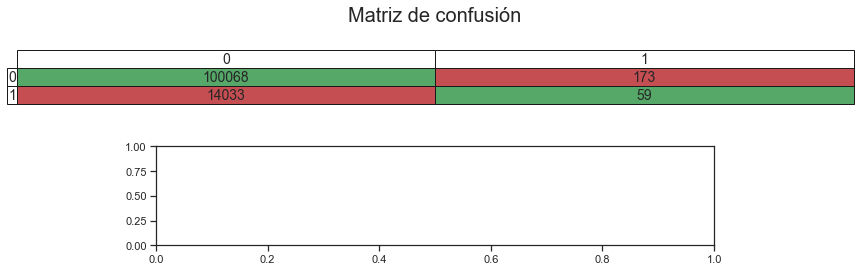

In [178]:
cm = confusion_matrix(y_test, predictions)
log_model_acc = accuracy_score(predictions, y_test)

print('Precisión del modelo: ', log_model_acc)
print('REPORT:\n', classification_report(y_test, predictions))

fig, ax =plt.subplots(2, 1, figsize=(10,4))

labels =['0', '1']
ax[0].axis('tight')
ax[0].axis('off')
colors = [['g', 'r'],[ 'r', 'g']]

conf_matrix_table = ax[0].table(   cellText = cm, 
                                    colLabels = labels,
                                    rowLabels = labels,    
                                    loc = 'center',   
                                    cellColours = colors, 
                                    cellLoc = 'center')


ax[0].set_title('Matriz de confusión', fontsize = 20)
conf_matrix_table.auto_set_font_size(False)
conf_matrix_table.set_fontsize(8)
conf_matrix_table.set_fontsize(14)
conf_matrix_table.scale(1.5, 1.5)

#sns.scatterplot(data=x_test, y='Region_Code', ax=ax[1])

#plt.show()

#### Visualización del modelo

In [179]:
x_test['Response'] = y_test
x_test['Prediction'] = predictions.tolist()

display(x_test[x_test['Prediction'] == 1].head(50))

,Age,Annual_Premium,Vintage,Driving_License,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Gender_Female,Gender_Male,...,Region_Code_45.0,Region_Code_46.0,Region_Code_47.0,Region_Code_48.0,Region_Code_49.0,Region_Code_50.0,Region_Code_51.0,Region_Code_52.0,Response,Prediction
122533,0.203242,0.037685,-0.222826,0,0,1,31196.0,136,0,1,...,0,0,0,0,0,0,0,0,0,1
350110,-1.150957,0.439916,-0.210864,1,0,1,38156.0,137,0,1,...,0,0,0,0,0,0,0,0,0,1
85305,-0.828529,-1.613196,-1.227617,1,0,1,2630.0,52,1,0,...,0,0,0,0,0,0,0,0,0,1
274842,-1.021986,1.346381,-0.174979,1,0,1,53841.0,140,0,1,...,0,0,0,0,0,0,0,0,0,1
230870,-1.021986,0.436333,-0.450100,1,0,1,38094.0,117,0,1,...,0,0,0,0,0,0,0,0,0,1
370795,-0.699557,-0.485562,-1.191731,1,0,1,22142.0,55,0,1,...,0,0,0,0,0,0,0,0,1,1
104373,-1.150957,-1.613196,1.081010,1,0,1,2630.0,245,1,0,...,0,0,0,0,0,0,0,0,0,1
324070,-1.086471,0.067275,-1.454891,1,0,1,31708.0,33,0,1,...,0,0,0,0,0,0,0,0,0,1
283846,-1.086471,-1.613196,0.793927,1,0,1,2630.0,221,0,1,...,0,0,0,0,0,0,0,0,0,1
257274,-0.570586,0.221637,-1.514700,1,0,1,34379.0,28,0,1,...,0,0,0,0,0,0,0,0,0,1


### Análisis kNN